<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/coli/ERA5_NDVI_NDBI_ALBEDO_'14_'23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script by Eco ERA5

In [ ]:
!pip install earthengine-api --upgrade
!pip install geemap --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.2/463.2 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.3/631.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


In [ ]:
import ee, pandas as pd
import geemap

In [ ]:
ee.Authenticate()
ee.Initialize(project='data-scrapping-470316')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [ ]:
# ERA5-Land Daily Aggregates dataset
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
  .filterDate('2014-01-01', '2024-01-01')

In [ ]:
# Print available variables (bands)
bands = dataset.first().bandNames().getInfo()
print("Available Bands:", bands)
print("Dataset size:", dataset.size().getInfo())

Available Bands: ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum', 'evaporation_from_bare_soil_sum', 'evaporation_from_open_water_surfaces_excludi

In [ ]:
# FIXED: Corrected coordinates for baler, Philippines
baler = ee.Geometry.Point([121.970536,  20.427284]).buffer(25000)  # [longitude, latitude]
print("Geometry created:", baler.getInfo())

def extract(img):
    # Add error handling and debugging
    vals = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=baler,
        scale=11132,  # ERA5-Land native resolution is ~11km
        maxPixels=1e13,
        bestEffort=True  # Add this to handle large geometries
    )

    # Get the date
    date_val = img.date().format("YYYY-MM-dd")

    # Create feature with both values and date
    feature = ee.Feature(None, vals).set("date", date_val)
    return feature

# Apply extraction to all images
fc = dataset.map(extract)

Geometry created: {'type': 'Polygon', 'coordinates': [[[121.97053600000001, 20.65225564878704], [121.90338716124897, 20.643288882306127], [121.84160547459979, 20.617105362582638], [121.79012388896176, 20.575797413657597], [121.75304374153019, 20.522663786501155], [121.7333072757712, 20.461943726982682], [121.73246643854283, 20.39847646478299], [121.75056536522541, 20.337314189066134], [121.78614398290162, 20.283319870392138], [121.83636022252226, 20.24078192452345], [121.8972192856551, 20.21307582571173], [121.96389082629514, 20.20239868027073], [122.03108908508008, 20.209596890825473], [122.09348706550985, 20.23409985646023], [122.14613378328285, 20.27396466317643], [122.1848434366507, 20.326028426625697], [122.20652703578881, 20.386156859461035], [122.20944060624039, 20.44957025308714], [122.19332954187226, 20.511221888913735], [122.15945593935045, 20.566199412245833], [122.11050454097996, 20.61011735199697], [122.05037273533242, 20.63946909383302], [121.9838601156185, 20.65190938814

In [ ]:
# Debug: Check if feature collection is properly created
print("Feature collection size:", fc.size().getInfo())

# Get a sample to check if data extraction worked
sample = fc.limit(5).getInfo()
print("Sample features:", sample['features'][0]['properties'])

Feature collection size: 3652
Sample features: {'date': '2014-01-01'}


In [ ]:
# Extract dates and data
dates = fc.aggregate_array("date").getInfo()
print(f"Number of dates extracted: {len(dates)}")
print(f"First few dates: {dates[:5]}")

var_names = dataset.first().bandNames().getInfo()
print(f"Variable names: {var_names}")

Number of dates extracted: 3652
First few dates: ['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05']
Variable names: ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'su

In [ ]:
# FIXED: Better error handling for data extraction
data = {}
for v in var_names:
    try:
        values = fc.aggregate_array(v).getInfo()
        data[v] = values
        print(f"Extracted {len([x for x in values if x is not None])} non-null values for {v}")
    except Exception as e:
        print(f"Error extracting {v}: {e}")
        data[v] = [None] * len(dates)

# Create DataFrame
df = pd.DataFrame({"date": dates})

Extracted 0 non-null values for dewpoint_temperature_2m
Extracted 0 non-null values for temperature_2m
Extracted 0 non-null values for skin_temperature
Extracted 0 non-null values for soil_temperature_level_1
Extracted 0 non-null values for soil_temperature_level_2
Extracted 0 non-null values for soil_temperature_level_3
Extracted 0 non-null values for soil_temperature_level_4
Extracted 0 non-null values for lake_bottom_temperature
Extracted 0 non-null values for lake_ice_depth
Extracted 0 non-null values for lake_ice_temperature
Extracted 0 non-null values for lake_mix_layer_depth
Extracted 0 non-null values for lake_mix_layer_temperature
Extracted 0 non-null values for lake_shape_factor
Extracted 0 non-null values for lake_total_layer_temperature
Extracted 0 non-null values for snow_albedo
Extracted 0 non-null values for snow_cover
Extracted 0 non-null values for snow_density
Extracted 0 non-null values for snow_depth
Extracted 0 non-null values for snow_depth_water_equivalent
Extrac

In [ ]:
# Add data columns with null checking
for v in var_names:
    if v in data:
        df[v] = data[v]
        null_count = df[v].isnull().sum()
        print(f"Column {v}: {len(df[v]) - null_count} valid values, {null_count} null values")

print("\nDataFrame shape:", df.shape)
print("DataFrame info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

ValueError: Length of values (0) does not match length of index (3652)

In [ ]:
# Unit conversions (only if data exists)
metadata = []
for col in df.columns:
    if col == "date":
        continue

    # Skip if all values are null
    if df[col].isnull().all():
        print(f"Skipping {col} - all values are null")
        continue

    original_name = col
    original_unit = "varies"
    converted_unit = original_unit
    new_name = col

    # Kelvin → Celsius
    if "temperature" in col.lower():
        df[col] = df[col] - 273.15
        new_name = col + "_C"
        original_unit, converted_unit = "K", "°C"
    # Precipitation / Runoff / Evaporation (m → mm/day)
    elif col.endswith("_sum") or "precipitation" in col.lower() or "evaporation" in col.lower() or "runoff" in col.lower():
        df[col] = df[col] * 1000
        new_name = col + "_mm"
        original_unit, converted_unit = "m", "mm/day"
    # Pressure (Pa → hPa)
    elif "pressure" in col.lower():
        df[col] = df[col] / 100
        new_name = col + "_hPa"
        original_unit, converted_unit = "Pa", "hPa"
    # Wind (m/s → km/h)
    elif "u_component" in col.lower() or "v_component" in col.lower() or "wind" in col.lower():
        df[col] = df[col] * 3.6
        new_name = col + "_kmh"
        original_unit, converted_unit = "m/s", "km/h"
    # Snow depth (m → cm)
    elif "snow_depth" in col.lower():
        df[col] = df[col] * 100
        new_name = col + "_cm"
        original_unit, converted_unit = "m", "cm"
    # Radiation & Fluxes (J/m²/day → W/m²)
    elif col.endswith("_radiation_sum") or col.endswith("_flux_sum") or col.endswith("_heat_sum"):
        df[col] = df[col] / 86400
        new_name = col + "_Wm2"
        original_unit, converted_unit = "J/m²/day", "W/m²"

    # Rename column
    if new_name != col:
        df.rename(columns={col: new_name}, inplace=True)

    # Add metadata record
    metadata.append({
        "Band": original_name,
        "Converted Column": new_name,
        "Original Unit": original_unit,
        "Converted Unit": converted_unit
    })

In [ ]:
# Build metadata DataFrame
meta_df = pd.DataFrame(metadata)
print("\nMetadata:")
print(meta_df)

In [ ]:
from google.colab import files

filename = "ERA5_Baler.csv"
df.to_csv(filename, index=False)

# --- Download ---
files.download(filename)


# NDVI

In [ ]:
def extract_and_process_viirs(point, dataset):
    def extract(img):
        vals = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=500,          # VIIRS ~500m resolution
            maxPixels=1e13
        )
        return ee.Feature(None, vals).set("date", img.date().format("YYYY-MM-dd"))

    # Map over dataset
    fc = dataset.map(extract)
    features = fc.getInfo()["features"]

    rows = []
    for f in features:
        props = f["properties"]
        row = {
            "date": props.get("date"),
            "NDVI": props.get("NDVI", None),
            "TIMEOFDAY": props.get("TIMEOFDAY", None),
            "QA": props.get("QA", None)   # keep QA instead of dropping
        }
        rows.append(row)

    # Explicitly define all columns (so no "extra" blank ones appear)
    df = pd.DataFrame(rows, columns=["date", "NDVI", "TIMEOFDAY", "QA"])

    # Scale values according to metadata
    # if "NDVI" in df:
    #     df["NDVI"] = df["NDVI"].apply(lambda x: None if x is None else x * 0.0001)
    # if "TIMEOFDAY" in df:
    #     df["TIMEOFDAY"] = df["TIMEOFDAY"].apply(lambda x: None if x is None else x * 0.01)
    if "NDVI" in df:
          df["NDVI"] = df["NDVI"].apply(lambda x: None if x is None else x / 10000)


    # QA stays as raw integer bitmask

    return df


In [ ]:
# Print available variables (bands)
bands = dataset.first().bandNames().getInfo()
print("Available Bands:", bands)
print("Dataset size:", dataset.size().getInfo())

Available Bands: ['NDVI', 'TIMEOFDAY', 'QA']
Dataset size: 3636


In [ ]:
import ee
import pandas as pd
import geemap

cloud_project = 'data-scrapping-470316'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

dataset = ee.ImageCollection("NOAA/CDR/VIIRS/NDVI/V1").filterDate('2014-01-01', '2024-01-01')

# 1. Define ee.Geometry.Point objects for each of the four additional stations
appari_point = ee.Geometry.Point([121.630454,  18.360059]).buffer(50000)
basco_point = ee.Geometry.Point([121.970536,  20.427284]).buffer(50000)
baler_point = ee.Geometry.Point([121.632028,  15.748809]).buffer(50000)
ambulong_point = ee.Geometry.Point([121.0552444,  14.09008056]).buffer(50000)
cabanatuan_point = ee.Geometry.Point(([120.951143,  15.470387])).buffer(50000)


# 2. Create a dictionary to store the station names and their corresponding point geometries
stations = {
    "Appari":  appari_point,
    "Basco": basco_point,
    "Baler": baler_point,
    "Ambulong": ambulong_point,
    "Cabanatuan": cabanatuan_point
}

# 3. and 4. Iterate through the stations and extract/process data
station_dataframes = {}
for station_name, station_point in stations.items():
    print(f"Extracting data for {station_name}...")
    try:
        df_station = extract_and_process_viirs(station_point, dataset)
        station_dataframes[station_name] = df_station
        filename = f"NDVI_{station_name}.csv"
        df_station.to_csv(filename, index=False)
        files.download(filename)
        print(f"✅ Saved {filename} with shape {df_station.shape}")
    except Exception as e:
        print(f"❌ Error for {station_name}: {e}")

Extracting data for Appari...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved NDVI_Appari.csv with shape (3636, 4)
Extracting data for Basco...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved NDVI_Basco.csv with shape (3636, 4)
Extracting data for Baler...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved NDVI_Baler.csv with shape (3636, 4)
Extracting data for Ambulong...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved NDVI_Ambulong.csv with shape (3636, 4)
Extracting data for Cabanatuan...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Saved NDVI_Cabanatuan.csv with shape (3636, 4)


# NDBI


In [1]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os


In [2]:
cloud_project = 'data-scrapping-470316'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
# 1. Define ee.Geometry.Point objects for each of the four additional stations
appari_point = ee.Geometry.Point([121.630454,  18.360059]).buffer(50000)
basco_point = ee.Geometry.Point([121.970536,  20.427284]).buffer(50000)
baler_point = ee.Geometry.Point([121.632028,  15.748809]).buffer(50000)
ambulong_point = ee.Geometry.Point([121.0552444,  14.09008056]).buffer(50000)
cabanatuan_point = ee.Geometry.Point(([120.951143,  15.470387])).buffer(50000)


# 2. Create a dictionary to store the station names and their corresponding point geometries
stations = {
    "Appari":  appari_point,
    "Basco": basco_point,
    "Baler": baler_point,
    "Ambulong": ambulong_point,
    "Cabanatuan": cabanatuan_point
}


In [4]:
def addNDBI_L8(img):
    nd = img.normalizedDifference(['SR_B6','SR_B5']).rename('NDBI')
    return img.addBands(nd).select('NDBI').copyProperties(img, ['system:time_start'])

def addNDBI_S2(img):
    nd = img.normalizedDifference(['B11','B8']).rename('NDBI')
    return img.addBands(nd).select('NDBI').copyProperties(img, ['system:time_start'])

In [5]:
start_date = '2014-01-01'
end_date = '2024-01-01'

l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
      .filterDate(start_date, '2017-03-28')
      .map(addNDBI_L8))

s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterDate('2017-03-28', end_date)   # Sentinel-2 availability
      .map(addNDBI_S2))

combined = l8.merge(s2).sort('system:time_start')


In [6]:
output_dir = "/content/NDBI_raw"
os.makedirs(output_dir, exist_ok=True)

all_raw = {}

for station_name, geom in stations.items():
    print(f"\n--- Extracting raw NDBI for {station_name} ---")

    # Extract features
    ts = combined.map(lambda img: ee.Feature(
        None, {
            'date': img.date().format('YYYY-MM-dd'),
            'NDBI': img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=100,
                bestEffort=True
            ).get('NDBI'),
            'station': station_name
        }
    ))

    ts_fc = ee.FeatureCollection(ts)

    # Convert to DataFrame
    df = geemap.ee_to_df(ts_fc)
    if df.empty:
        print(f"No data extracted for {station_name}")
        continue

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

    # Save raw CSV
    raw_file = os.path.join(output_dir, f"{station_name}_NDBI_Raw.csv")
    df.to_csv(raw_file, index=False)
    print(f"Saved {raw_file} with {len(df)} records")

    all_raw[station_name] = df

print("\nFinished exporting raw NDBI CSVs for all stations!")



--- Extracting raw NDBI for Appari ---


Exception: Computation timed out.

In [1]:
# NDBI Extraction - Optimized to prevent timeouts
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os
import time
from datetime import datetime, timedelta

cloud_project = 'data-scrapping-470316'
try:
    ee.Initialize(project=cloud_project)
    print("✅ Earth Engine initialized successfully")
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)
    print("✅ Authentication complete")

# Define stations with smaller buffers to reduce computation
stations = {
    "Appari": ee.Geometry.Point([121.630454, 18.360059]).buffer(25000),   # Reduced from 50km
    "Basco": ee.Geometry.Point([121.970536, 20.427284]).buffer(25000),
    "Baler": ee.Geometry.Point([121.632028, 15.748809]).buffer(25000),
    "Ambulong": ee.Geometry.Point([121.0552444, 14.09008056]).buffer(25000),
    "Cabanatuan": ee.Geometry.Point([120.951143, 15.470387]).buffer(25000)
}

def addNDBI_L8(img):
    """Optimized NDBI calculation for Landsat 8 with cloud masking"""
    # Simple cloud mask using QA_PIXEL
    qa = img.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))

    # Calculate NDBI
    ndbi = img.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

    return img.addBands(ndbi).select('NDBI').updateMask(cloud_mask).copyProperties(img, ['system:time_start'])

def addNDBI_S2(img):
    """Optimized NDBI calculation for Sentinel-2 with cloud masking"""
    # Simple cloud mask using SCL band
    scl = img.select('SCL')
    cloud_mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))

    # Calculate NDBI
    ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')

    return img.addBands(ndbi).select('NDBI').updateMask(cloud_mask).copyProperties(img, ['system:time_start'])

def process_time_chunks(collection, geom, station_name, chunk_months=6):
    """Process data in time chunks to avoid timeouts"""
    print(f"Processing {station_name} in {chunk_months}-month chunks...")

    start_date = datetime(2014, 1, 1)
    end_date = datetime(2024, 1, 1)
    current_date = start_date

    all_chunks = []
    chunk_count = 0

    while current_date < end_date:
        chunk_end = min(current_date + timedelta(days=chunk_months * 30), end_date)

        print(f"  Chunk {chunk_count + 1}: {current_date.strftime('%Y-%m-%d')} to {chunk_end.strftime('%Y-%m-%d')}")

        # Filter collection for this time chunk and geometry
        chunk_collection = (collection
                          .filterDate(current_date.strftime('%Y-%m-%d'),
                                    chunk_end.strftime('%Y-%m-%d'))
                          .filterBounds(geom)
                          .limit(100))  # Limit images per chunk

        # Check if chunk has data
        chunk_size = chunk_collection.size().getInfo()
        print(f"    Images in chunk: {chunk_size}")

        if chunk_size == 0:
            current_date = chunk_end
            continue

        try:
            # Extract features for this chunk
            ts = chunk_collection.map(lambda img: ee.Feature(
                None, {
                    'date': img.date().format('YYYY-MM-dd'),
                    'NDBI': img.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=geom,
                        scale=500,  # Increased scale to reduce computation
                        bestEffort=True,
                        maxPixels=1e8
                    ).get('NDBI'),
                    'station': station_name,
                    'chunk': chunk_count
                }
            ))

            ts_fc = ee.FeatureCollection(ts)

            # Convert to DataFrame with timeout handling
            chunk_df = geemap.ee_to_df(ts_fc)

            if not chunk_df.empty:
                chunk_df['date'] = pd.to_datetime(chunk_df['date'], errors='coerce')
                chunk_df = chunk_df.dropna(subset=['date', 'NDBI'])
                all_chunks.append(chunk_df)
                print(f"    ✅ Processed {len(chunk_df)} records")
            else:
                print(f"    ⚠️ No valid data in chunk")

            # Small delay to prevent rate limiting
            time.sleep(1)

        except Exception as e:
            print(f"    ❌ Error processing chunk: {str(e)}")
            # Continue with next chunk instead of failing completely

        current_date = chunk_end
        chunk_count += 1

    # Combine all chunks
    if all_chunks:
        combined_df = pd.concat(all_chunks, ignore_index=True)
        combined_df = combined_df.sort_values('date').reset_index(drop=True)
        return combined_df
    else:
        return pd.DataFrame()

def process_station_by_year(collection, geom, station_name):
    """Alternative approach: process one year at a time"""
    print(f"Processing {station_name} year by year...")

    all_years = []

    for year in range(2014, 2024):
        print(f"  Processing year {year}...")

        year_start = f"{year}-01-01"
        year_end = f"{year + 1}-01-01"

        # Filter for this year
        year_collection = (collection
                         .filterDate(year_start, year_end)
                         .filterBounds(geom)
                         .limit(50))  # Limit images per year

        year_size = year_collection.size().getInfo()
        print(f"    Images available: {year_size}")

        if year_size == 0:
            continue

        try:
            # Process year
            ts = year_collection.map(lambda img: ee.Feature(
                None, {
                    'date': img.date().format('YYYY-MM-dd'),
                    'NDBI': img.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=geom,
                        scale=500,
                        bestEffort=True,
                        maxPixels=1e8
                    ).get('NDBI'),
                    'station': station_name,
                    'year': year
                }
            ))

            ts_fc = ee.FeatureCollection(ts)
            year_df = geemap.ee_to_df(ts_fc)

            if not year_df.empty:
                year_df['date'] = pd.to_datetime(year_df['date'], errors='coerce')
                year_df = year_df.dropna(subset=['date', 'NDBI'])
                all_years.append(year_df)
                print(f"    ✅ {len(year_df)} records")

            time.sleep(0.5)  # Brief pause

        except Exception as e:
            print(f"    ❌ Error processing year {year}: {str(e)}")
            continue

    if all_years:
        combined_df = pd.concat(all_years, ignore_index=True)
        return combined_df.sort_values('date').reset_index(drop=True)
    else:
        return pd.DataFrame()

# Prepare collections with better filtering
start_date = '2014-01-01'
end_date = '2024-01-01'
transition_date = '2017-03-28'

print("Loading and filtering satellite collections...")

# Landsat 8 with cloud filtering
l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
      .filterDate(start_date, transition_date)
      .filter(ee.Filter.lt('CLOUD_COVER', 70))  # More lenient cloud filter
      .map(addNDBI_L8))

# Sentinel-2 with cloud filtering
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterDate(transition_date, end_date)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 70))
      .map(addNDBI_S2))

combined = l8.merge(s2).sort('system:time_start')

print(f"Total images in combined collection: {combined.size().getInfo()}")

# Create output directory
output_dir = "/content/NDBI_raw_optimized"
os.makedirs(output_dir, exist_ok=True)

all_raw = {}
processing_method = "yearly"  # Change to "chunks" for chunk-based processing

for station_name, geom in stations.items():
    print(f"\n{'='*50}")
    print(f"PROCESSING: {station_name}")
    print(f"{'='*50}")

    try:
        if processing_method == "yearly":
            df = process_station_by_year(combined, geom, station_name)
        else:
            df = process_time_chunks(combined, geom, station_name, chunk_months=6)

        if df.empty:
            print(f"❌ No data extracted for {station_name}")
            continue

        # Clean and save data
        df = df.dropna(subset=['date', 'NDBI'])
        df = df.sort_values('date').reset_index(drop=True)

        # Remove extreme outliers
        Q1 = df['NDBI'].quantile(0.25)
        Q3 = df['NDBI'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df['NDBI'] >= lower_bound) & (df['NDBI'] <= upper_bound)]

        # Save raw CSV
        raw_file = os.path.join(output_dir, f"{station_name}_NDBI_Raw.csv")
        df.to_csv(raw_file, index=False)

        all_raw[station_name] = df

        print(f"✅ SUCCESS: Saved {raw_file} with {len(df)} records")
        print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"   NDBI range: {df['NDBI'].min():.3f} to {df['NDBI'].max():.3f}")

    except Exception as e:
        print(f"❌ FAILED: Error processing {station_name}: {str(e)}")
        continue

print(f"\n{'='*60}")
print("PROCESSING COMPLETE!")
print(f"{'='*60}")

if all_raw:
    print(f"Successfully processed {len(all_raw)} stations:")
    for station, df in all_raw.items():
        print(f"  • {station}: {len(df)} observations")

    # Create combined dataset
    if len(all_raw) > 1:
        combined_df = pd.concat(all_raw.values(), ignore_index=True)
        combined_file = os.path.join(output_dir, "All_Stations_NDBI_Combined.csv")
        combined_df.to_csv(combined_file, index=False)
        print(f"\n✅ Combined dataset saved: {combined_file}")
        print(f"   Total observations: {len(combined_df)}")

else:
    print("❌ No data was successfully extracted from any station")
    print("\nTroubleshooting suggestions:")
    print("1. Check if your coordinates are correct")
    print("2. Reduce buffer size further (try 10-15km)")
    print("3. Reduce the date range")
    print("4. Check your GEE project permissions")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


✅ Authentication complete
Loading and filtering satellite collections...


EEException: Computation timed out.

# Albedo

In [ ]:
!pip install earthengine-api geemap --upgrade

In [14]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter

In [15]:
ee.Authenticate()
ee.Initialize(project='data-scrapping-470316')

In [16]:
# --- Define stations ---
stations = {
    "Aparri": ee.Geometry.Point([121.630454, 18.360059]).buffer(25000),
    "Basco": ee.Geometry.Point([121.970536, 20.427284]).buffer(25000),
    "Baler": ee.Geometry.Point([121.632028, 15.748809]).buffer(25000),
    "Ambulong": ee.Geometry.Point([121.0552444, 14.09008056]).buffer(25000),
    "Cabanatuan": ee.Geometry.Point([120.951143, 15.470387]).buffer(25000)
}
start_date = "2014-01-01"   # MODIS MCD43 start
end_date   = "2024-01-01"
full_range = pd.date_range(start_date, end_date, freq="D")

albedo = ee.ImageCollection("MODIS/061/MCD43A3").filterDate(start_date, end_date)

In [17]:
sample = albedo.first()
sample.bandNames().getInfo()

['Albedo_BSA_Band1',
 'Albedo_BSA_Band2',
 'Albedo_BSA_Band3',
 'Albedo_BSA_Band4',
 'Albedo_BSA_Band5',
 'Albedo_BSA_Band6',
 'Albedo_BSA_Band7',
 'Albedo_BSA_vis',
 'Albedo_BSA_nir',
 'Albedo_BSA_shortwave',
 'Albedo_WSA_Band1',
 'Albedo_WSA_Band2',
 'Albedo_WSA_Band3',
 'Albedo_WSA_Band4',
 'Albedo_WSA_Band5',
 'Albedo_WSA_Band6',
 'Albedo_WSA_Band7',
 'Albedo_WSA_vis',
 'Albedo_WSA_nir',
 'Albedo_WSA_shortwave',
 'BRDF_Albedo_Band_Mandatory_Quality_Band1',
 'BRDF_Albedo_Band_Mandatory_Quality_Band2',
 'BRDF_Albedo_Band_Mandatory_Quality_Band3',
 'BRDF_Albedo_Band_Mandatory_Quality_Band4',
 'BRDF_Albedo_Band_Mandatory_Quality_Band5',
 'BRDF_Albedo_Band_Mandatory_Quality_Band6',
 'BRDF_Albedo_Band_Mandatory_Quality_Band7',
 'BRDF_Albedo_Band_Mandatory_Quality_vis',
 'BRDF_Albedo_Band_Mandatory_Quality_nir',
 'BRDF_Albedo_Band_Mandatory_Quality_shortwave']

In [20]:
def extract_albedo(geometry, station_name):
    print(f"\n--- Processing {station_name} ---")

    def process(img):
        # Select BSA and WSA bands
        bsa = img.select("Albedo_BSA_shortwave")
        wsa = img.select("Albedo_WSA_shortwave")

        # Compute BHA (mean of BSA & WSA, apply scaling)
        bha = bsa.add(wsa).divide(2).multiply(0.001)

        return ee.Feature(
            None,
            {
                "date": img.date().format("YYYY-MM-dd"),
                "BSA": bsa.reduceRegion(
                    ee.Reducer.mean(), geometry, 500
                ).get("Albedo_BSA_shortwave"),
                "WSA": wsa.reduceRegion(
                    ee.Reducer.mean(), geometry, 500
                ).get("Albedo_WSA_shortwave"),
                "BHA": bha.reduceRegion(
                    ee.Reducer.mean(), geometry, 500
                ).get(bha.bandNames().get(0)),  # reduceRegion on computed BHA
            },
        )

    features = albedo.map(process)
    features = ee.FeatureCollection(features)

    # Convert to DataFrame
    df = geemap.ee_to_df(features)

    if df.empty:
        print(f"No data for {station_name}")
        return None

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    # Reindex to full daily timeline
    full_range = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")
    df = df.set_index("date").reindex(full_range)

    # Interpolate missing values
    for col in ["BSA", "WSA", "BHA"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].interpolate(method="linear").ffill().bfill()

    df.index.name = "date"
    df = df.reset_index().rename(columns={"index": "date"})
    df["station"] = station_name

    # Save to CSV
    filename = f"{station_name}_Albedo.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {df.shape[0]} rows")

    return df


In [21]:

all_dfs = {}
for station, geom in stations.items():
    df_station = extract_albedo(geom, station)
    if df_station is not None:
        all_dfs[station] = df_station

print("\nProcessing complete!")


--- Processing Aparri ---
Saved Aparri_Albedo.csv with 3652 rows

--- Processing Basco ---
Saved Basco_Albedo.csv with 3652 rows

--- Processing Baler ---
Saved Baler_Albedo.csv with 3652 rows

--- Processing Ambulong ---
Saved Ambulong_Albedo.csv with 3652 rows

--- Processing Cabanatuan ---
Saved Cabanatuan_Albedo.csv with 3652 rows

Processing complete!


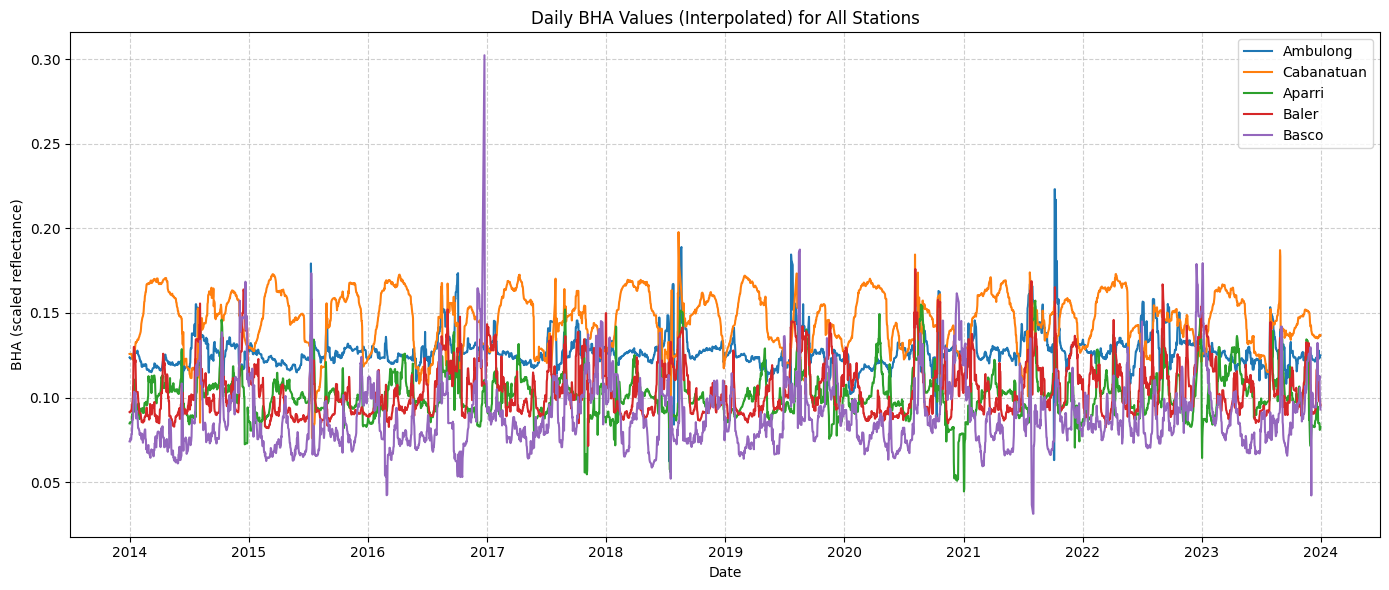

In [22]:

import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load all station CSVs
csv_files = glob.glob("*_Albedo.csv")

plt.figure(figsize=(14, 6))

for file in csv_files:
    df = pd.read_csv(file, parse_dates=["date"])
    station_name = file.split("_")[0].capitalize()

    # Plot BHA
    plt.plot(df["date"], df["BHA"], label=station_name)

plt.title("Daily BHA Values (Interpolated) for All Stations")
plt.xlabel("Date")
plt.ylabel("BHA (scaled reflectance)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()